In [48]:
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from random import shuffle
import numpy as np
import os
from PIL import Image
from torchvision import transforms
import random
import torch
from random import shuffle
import matplotlib.pyplot as plt

In [40]:
test_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])
    ])

In [41]:
def get_img_list(cat,d1):
    ret = list()
    for frame in os.listdir('data/data_first_25/{}/{}'.format(cat,d1)):
        img_pil = Image.open('data/data_first_25/{}/{}/{}'.format(cat,d1,frame))
        input_img = test_transform(img_pil).unsqueeze(0)
        ret.append(input_img)
    return ret

def createTrainAndValSet(categories,trainPercentage):
    category_options = os.listdir('data/data_first_25')
    category_names = category_options[:categories]
    train_set = []
    val_set = []
    i=0
    for cat in category_names:
        for d1 in os.listdir('data/data_first_25/{}'.format(cat)):
            r = random.uniform(0,1)
            img_list = get_img_list(cat,d1)
            if r < trainPercentage:
                train_set.append((img_list,i))
            else:
                val_set.append((img_list,i))
        i+=1
    return train_set,val_set

In [42]:
class AverageModel(nn.Module):
    def __init__(self, output_size=5):
        super(AverageModel, self).__init__()

        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.output_size = output_size
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, output_size)
        
    def forward(self, x_3d):
        result = torch.zeros((1,self.output_size)).cuda()
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t, :, :, :])  # ResNet
                x = x.view(x.size(0), -1)             # flatten output of conv

            # FC layers
            x = self.fc1(x)
          
            result += x
        result /= x_3d.size(1)

        return result

In [54]:
train_accuracies = []; train_losses = [];
val_accuracies = []; val_losses = [];

def train_model(model, loss_fn, optimizer, epochs):
    model = model.cuda()
    loss_fn = loss_fn.cuda()
    batchSize = 1

    for epoch in range(epochs):
        correct = 0
        cum_loss = 0

        i = 0
        model.train()
        shuffle(train_set)
        for video in train_set:
            frame_list, target_cat = video
            frame_list = torch.stack(frame_list, dim=0).transpose(0, 1).cuda()
            scores = model(frame_list)
            
            loss = loss_fn(scores, torch.tensor(np.array([target_cat]),dtype=torch.long).cuda())
            max_score, max_label = scores.max(1)
            if max_label == target_cat:
                correct+=1
            cum_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i + 1) % 100 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))
            i += 1
            
        train_accuracies.append(correct / len(train_set))
        train_losses.append(cum_loss / (i + 1))   
        
        i = 0
        correct = 0
        cum_loss = 0
        model.eval()
        for video in val_set:
            frame_list, target_cat = video
            frame_list = torch.stack(frame_list, dim=0).transpose(0, 1).cuda()
            scores = model(frame_list)
            
            loss = loss_fn(scores, torch.tensor(np.array([target_cat]),dtype=torch.long).cuda())
            max_score, max_label = scores.max(1)
            if max_label == target_cat:
                correct+=1
            cum_loss += loss.item()
            
            i += 1
        print('Validation-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
               (epoch, i + 1, cum_loss / (i + 1), correct / len(val_set)))
        
        val_accuracies.append(correct / len(val_set))
        val_losses.append(cum_loss / (i + 1))

In [44]:
categories = 15

train_set, val_set = createTrainAndValSet(categories, 0.8)

In [ ]:
learning_rate = 5e-3

my_model = AverageModel(output_size=categories)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)
epochs = 100

train_model(my_model, loss_fn, optimizer, epochs)

Train-epoch 0. Iteration 00100, Avg-Loss: 9.8029, Accuracy: 0.0900
Train-epoch 0. Iteration 00200, Avg-Loss: 8.7097, Accuracy: 0.0750
Train-epoch 0. Iteration 00300, Avg-Loss: 9.0822, Accuracy: 0.0867
Train-epoch 0. Iteration 00400, Avg-Loss: 8.8617, Accuracy: 0.0775
Train-epoch 0. Iteration 00500, Avg-Loss: 8.8387, Accuracy: 0.0780
Train-epoch 0. Iteration 00600, Avg-Loss: 8.7142, Accuracy: 0.0750
Train-epoch 0. Iteration 00700, Avg-Loss: 8.4384, Accuracy: 0.0786
Train-epoch 0. Iteration 00800, Avg-Loss: 8.4210, Accuracy: 0.0737
Train-epoch 0. Iteration 00900, Avg-Loss: 8.4473, Accuracy: 0.0767
Train-epoch 0. Iteration 01000, Avg-Loss: 8.4261, Accuracy: 0.0730
Train-epoch 0. Iteration 01100, Avg-Loss: 8.4531, Accuracy: 0.0727
Train-epoch 0. Iteration 01200, Avg-Loss: 8.5309, Accuracy: 0.0717
Train-epoch 0. Iteration 01300, Avg-Loss: 8.5403, Accuracy: 0.0708
Train-epoch 0. Iteration 01400, Avg-Loss: 8.5726, Accuracy: 0.0743
Train-epoch 0. Iteration 01500, Avg-Loss: 8.4987, Accuracy: 0.

In [47]:
# These are not from the ones above. This was from an earlier run with only 10 epochs. 
print(train_accuracies)
print(val_accuracies)

[0.07935523868567886, 0.08617482951022938, 0.09671419714817112, 0.09547427154370738, 0.12337259764414135, 0.11841289522628642, 0.14879107253564786, 0.16181029138251704, 0.15933044017358958, 0.18412895226286422]
[0.23058823529411765, 0.3058823529411765, 0.2211764705882353, 0.24235294117647058, 0.32941176470588235, 0.3035294117647059, 0.34823529411764703, 0.4541176470588235, 0.40705882352941175, 0.4376470588235294]


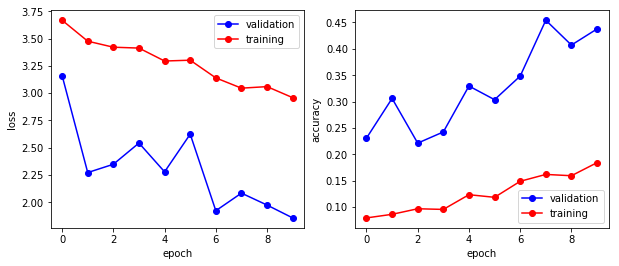

In [49]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()